In [10]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import ruptures as rpt
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters

from pyod.models.copod import COPOD
import skimage as ski
from skimage import util as skiutil
register_matplotlib_converters()

In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans0='TemperatureKmeansScore0'
kmeans='TemperatureKmeansScore'
fft0='FFTAnomalyScore0'
mat0='MatrixProfileAnomalyScore'
fft='FFTAnomalyScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansA0='kmeansAnomaly0'
spectralA='spectralAnomaly'
fftA0='fftAnomaly0'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'
matA0='matAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000
mat_break = 1

In [7]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('./data/AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i[Temperature]=df_i['value']
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

value  Temperature
entity timestamp                              
MyRoom 2017-10-09 20:32:00    3.0          3.0
       2017-10-09 20:33:00    3.0          3.0

In [16]:
# data is evenly spaced, no need to resample - just extract

temperature = df_i['value'].values
temp_win = skiutil.view_as_windows(temperature, window_shape=(2,), step=1)

In [17]:
# turned my data into 2-dim vectors for anomaly scoring
temp_win.shape

(3999, 2)

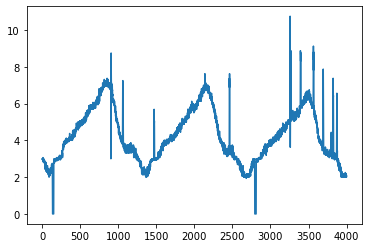

In [19]:
#plot original
plt.plot(range(len(temperature)), temperature)

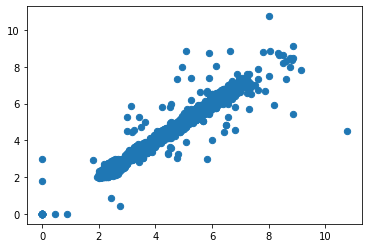

In [21]:
# plot 2-dim
plt.scatter(temp_win[:, 0], temp_win[:, 1], s=40, cmap='viridis');

### Apply COPOD

as well as ECOD

For java have a look at [EmpiricalDistribution in Common Math](https://commons.apache.org/proper/commons-math/javadocs/api-3.6/org/apache/commons/math3/random/EmpiricalDistribution.html) and [Skewness in Common Math](https://commons.apache.org/proper/commons-math/javadocs/api-3.6/org/apache/commons/math3/stat/descriptive/moment/Skewness.html)

In [114]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import skew
def ecdf(X):
    ecdf = ECDF(X)
    return ecdf(X)

In [115]:
temp_win.shape

(3999, 2)

In [116]:
# compute P({t < x}) and P({t < -x}) for each x according to the empirical CDF ()
#
left_log_univariate_cdfs = -1 * np.log(np.apply_along_axis(ecdf, 0, temp_win))
right_log_univariate_cdfs = -1 * np.log(np.apply_along_axis(ecdf, 0, -temp_win))

In [117]:
left_log_univariate_cdfs.shape

(3999, 2)

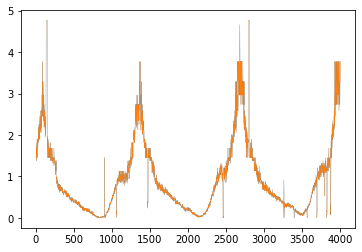

In [118]:
plt.plot(range(len(left_log_univariate_cdf[:, 0])), left_log_univariate_cdf[:,0], lw=0.2)
plt.plot(range(len(left_log_univariate_cdf[:, 1])), left_log_univariate_cdf[:,1], lw=0.2);

In [119]:
# COPOD: adjust for skewness (more weight on left or right tail) for each dimension
skewness = np.sign(skew(temp_win, axis=0))

# apply skewness for each dimension: either take from the right or the left tail.
U_skew = left_log_univariate_cdfs * -1 * np.sign(skewness - 1) + right_log_univariate_cdfs  * np.sign(skewness + 1)
O = np.maximum(U_skew, np.add(left_log_univariate_cdfs, right_log_univariate_cdfs) / 2)

In [120]:
# ECOD
O_ecod = np.maximum(U_skew, left_log_univariate_cdfs, right_log_univariate_cdfs)

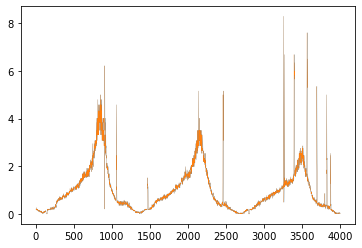

In [121]:
plt.plot(range(len(U_skew[:, 0])), U_skew[:,0], lw=0.2)
plt.plot(range(len(U_skew[:, 1])), U_skew[:,1], lw=0.2);

In [122]:
decision_score = O.sum(axis=1)
decision_score_e = O_ecod.sum(axis=1)

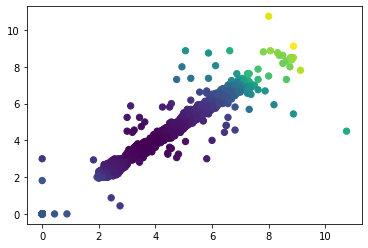

In [123]:
# outliers in 2-d
plt.scatter(temp_win[:, 0], temp_win[:, 1], c=decision_score, s=40, cmap='viridis');

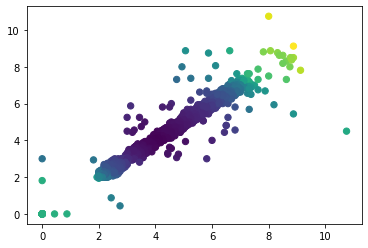

In [124]:
# outliers in 2-d - ECOD
plt.scatter(temp_win[:, 0], temp_win[:, 1], c=decision_score_e, s=40, cmap='viridis');

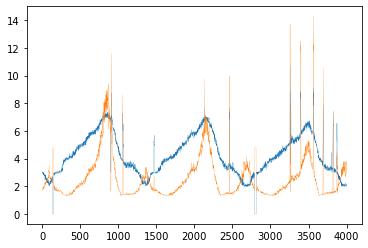

In [125]:
plt.plot(range(len(temperature)), temperature, lw=0.2)
plt.plot(range(len(decision_score)), score, lw=0.2);